In [13]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta
from openpyxl import Workbook


In [14]:
# Load the events file
df = pd.read_csv("EVENTS_corrected.csv")
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={'date (dd.mm.yyyy)': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')  # <- FIXED LINE

In [15]:
# Download market index data (e.g., S&P 500)
market_symbol = "^GSPC"
start_date = df['date'].min() - timedelta(days=120)
end_date = df['date'].max() + timedelta(days=10)
market = yf.download(market_symbol, start=start_date, end=end_date, auto_adjust=True)['Close']
market.name = "market"

# Define event window
pre_event = 100
post_event = 5

# Store results
car_results = {}
ar_results = {}

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

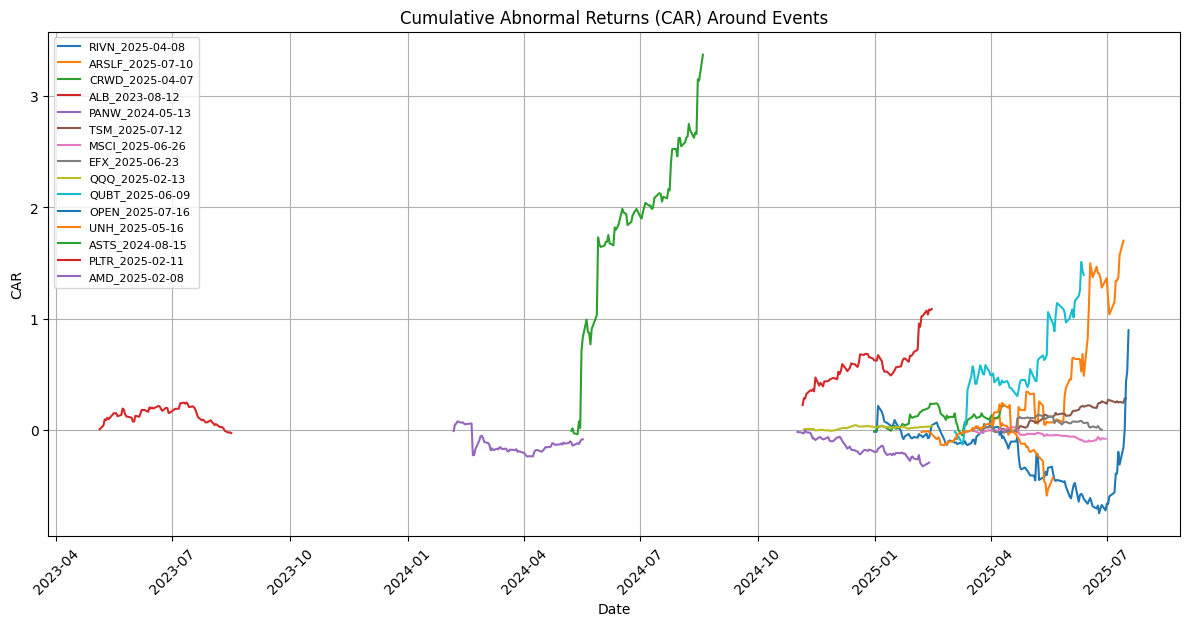

AR and CAR results saved to Event_Study_Results.xlsx

Abnormal Returns (AR) for Each Event:

RIVN_2025-04-08:
Date
2024-12-30         NaN
2024-12-31   -0.016334
2025-01-02   -0.001536
2025-01-03    0.231932
2025-01-06   -0.052536
                ...   
2025-04-07    0.002331
2025-04-08   -0.020874
2025-04-09   -0.005339
2025-04-10    0.008269
2025-04-11   -0.017219
Name: AR, Length: 71, dtype: float64

------------------------------------------------------------

ARSLF_2025-07-10:
Date
2025-04-01         NaN
2025-04-02   -0.006728
2025-04-03    0.048396
2025-04-04    0.059750
2025-04-07    0.002331
                ...   
2025-07-08    0.191701
2025-07-09    0.000736
2025-07-10    0.030668
2025-07-11    0.198818
2025-07-14    0.130020
Name: AR, Length: 71, dtype: float64

------------------------------------------------------------

CRWD_2025-04-07:
Date
2024-12-30         NaN
2024-12-31   -0.016184
2025-01-02    0.017363
2025-01-03    0.021031
2025-01-06    0.014906
                ...

In [16]:
# Loop through each event
for index, row in df.iterrows():
    symbol = row['ticker']
    event_date = row['date']

    # Define window range
    start = event_date - timedelta(days=pre_event)
    end = event_date + timedelta(days=post_event)

    # Download stock data
    try:
        stock_data = yf.download(symbol, start=start, end=end, auto_adjust=True)
        if 'Close' not in stock_data.columns:
            print(f"No 'Close' data for {symbol}. Skipping.")
            continue
        stock_close = stock_data['Close']
        stock_close.name = "stock"
    except Exception as e:
        print(f"Failed to get data for {symbol}: {e}")
        continue

    # Combine stock and market data
    combined = pd.concat([stock_close, market], axis=1).dropna()
    combined.columns = ['stock', 'market']

    # Compute returns
    stock_returns = combined['stock'].pct_change()
    market_returns = combined['market'].pct_change()
    abnormal_returns = stock_returns - market_returns
    abnormal_returns.name = "AR"
    car = abnormal_returns.cumsum()
    car.name = "CAR"

    # Save AR and CAR
    event_key = f"{symbol}_{event_date.date()}"
    ar_results[event_key] = abnormal_returns
    car_results[event_key] = car

# Plot CAR for all events on one graph
plt.figure(figsize=(12, 6))
for key, car_series in car_results.items():
    plt.plot(car_series.index, car_series.values, label=key)
plt.title("Cumulative Abnormal Returns (CAR) Around Events")
plt.xlabel("Date")
plt.ylabel("CAR")
plt.legend(loc='best', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Save AR and CAR to Excel with each event in a separate sheet
with pd.ExcelWriter("Event_Study_Results.xlsx") as writer:
    for key in ar_results:
        df_event = pd.concat([ar_results[key], car_results[key]], axis=1)
        df_event.to_excel(writer, sheet_name=key[:31])  # Sheet name max 31 chars

print("AR and CAR results saved to Event_Study_Results.xlsx")

# Print AR like you did for CAR
print("\nAbnormal Returns (AR) for Each Event:\n")
for key, ar_series in ar_results.items():
    print(f"{key}:")
    print(ar_series)
    print("\n" + "-"*60 + "\n")

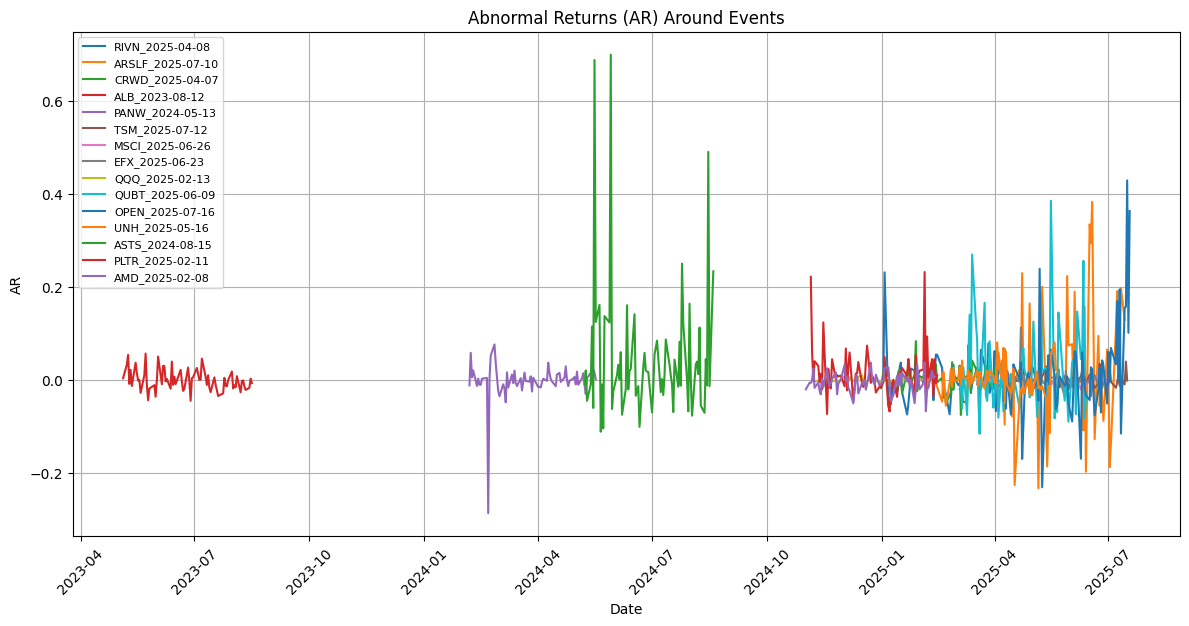

In [17]:
# Plot AR for all events
plt.figure(figsize=(12, 6))
for key, ar_series in ar_results.items():
    plt.plot(ar_series.index, ar_series.values, label=key)
plt.title("Abnormal Returns (AR) Around Events")
plt.xlabel("Date")
plt.ylabel("AR")
plt.legend(loc='best', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

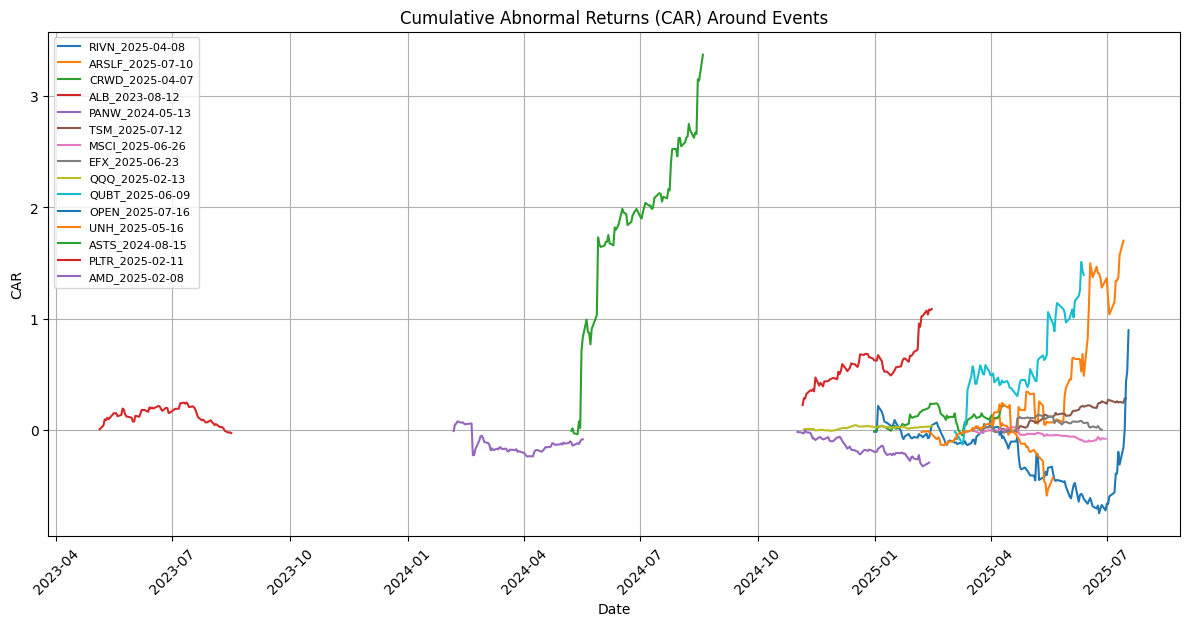

In [18]:
# Plot CAR for all events on one graph
plt.figure(figsize=(12, 6))
for key, car_series in car_results.items():
    plt.plot(car_series.index, car_series.values, label=key)
plt.title("Cumulative Abnormal Returns (CAR) Around Events")
plt.xlabel("Date")
plt.ylabel("CAR")
plt.legend(loc='best', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Statistical test results saved to Event_Study_Results.xlsx


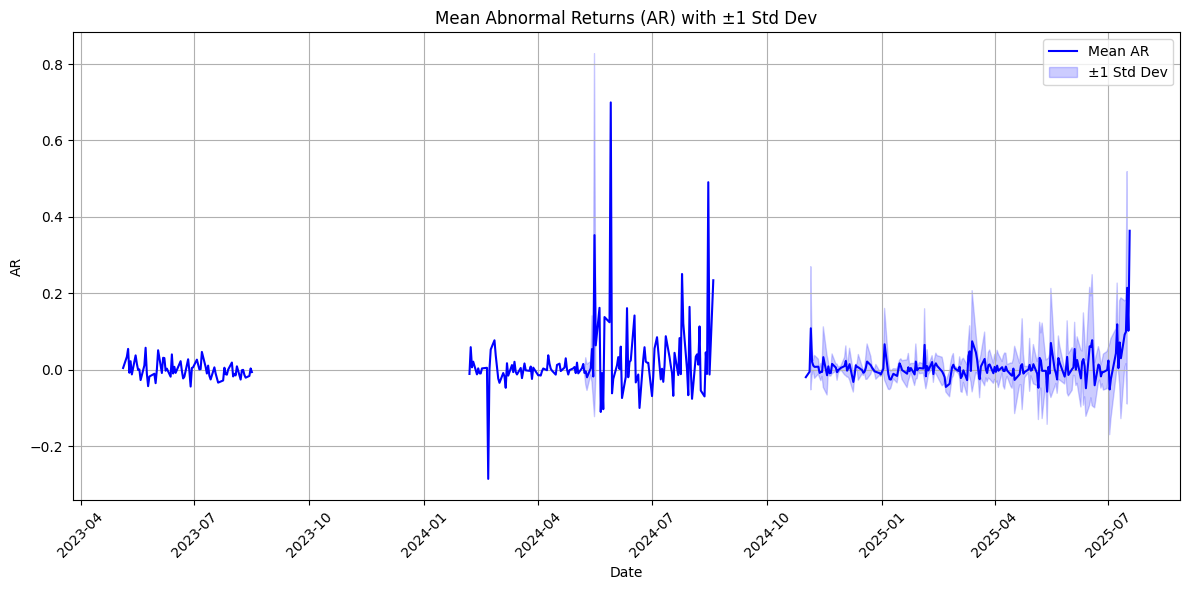

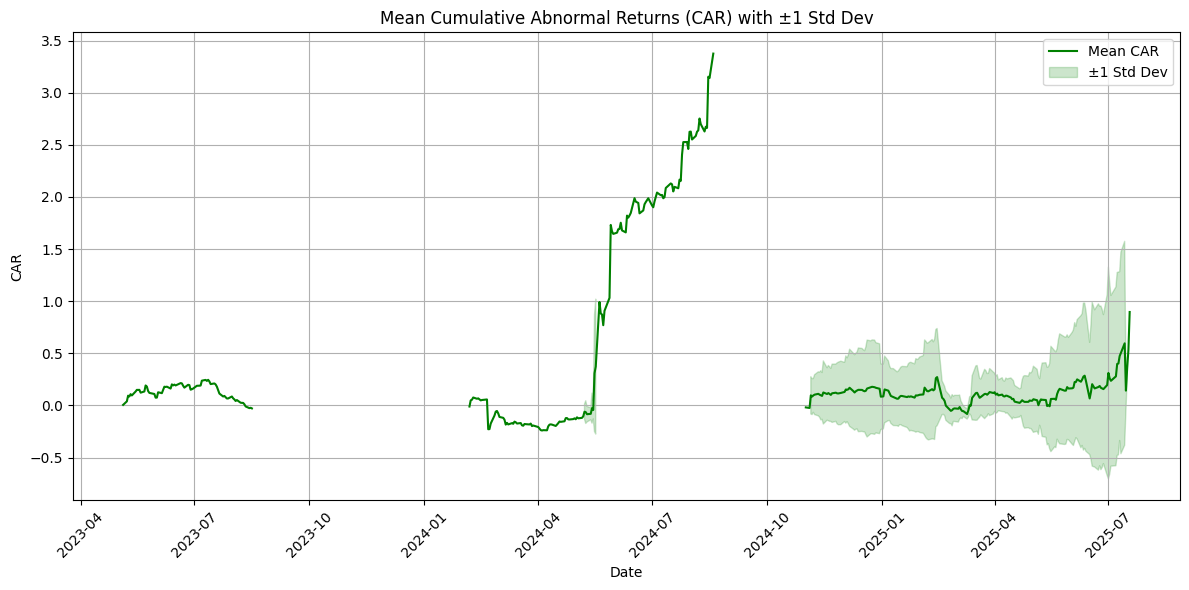

In [19]:
import numpy as np
from scipy import stats

# Aggregate AR and CAR into DataFrames
ar_df = pd.DataFrame(ar_results)
car_df = pd.DataFrame(car_results)

# Align index for consistency (some series may have different lengths due to missing data)
ar_df = ar_df.loc[ar_df.index.dropna()]
car_df = car_df.loc[car_df.index.dropna()]

# Calculate average and std deviation
mean_ar = ar_df.mean(axis=1)
std_ar = ar_df.std(axis=1)
mean_car = car_df.mean(axis=1)
std_car = car_df.std(axis=1)

# Calculate t-stats
t_stat_ar = mean_ar / (std_ar / np.sqrt(ar_df.shape[1]))
t_stat_car = mean_car / (std_car / np.sqrt(car_df.shape[1]))

# Calculate p-values
p_values_ar = stats.t.sf(np.abs(t_stat_ar), df=ar_df.shape[1]-1) * 2
p_values_car = stats.t.sf(np.abs(t_stat_car), df=car_df.shape[1]-1) * 2

# Combine stats into one DataFrame
summary_stats = pd.DataFrame({
    'Mean_AR': mean_ar,
    'Std_AR': std_ar,
    'T_AR': t_stat_ar,
    'P_AR': p_values_ar,
    'Mean_CAR': mean_car,
    'Std_CAR': std_car,
    'T_CAR': t_stat_car,
    'P_CAR': p_values_car
})

# Save stats to Excel
with pd.ExcelWriter("Event_Study_Results.xlsx", mode='a', engine='openpyxl') as writer:
    summary_stats.to_excel(writer, sheet_name="Statistics")

print("Statistical test results saved to Event_Study_Results.xlsx")

# Plot average AR with ±1 std deviation
plt.figure(figsize=(12, 6))
plt.plot(mean_ar.index, mean_ar, label="Mean AR", color='blue')
plt.fill_between(mean_ar.index, mean_ar - std_ar, mean_ar + std_ar, color='blue', alpha=0.2, label='±1 Std Dev')
plt.title("Mean Abnormal Returns (AR) with ±1 Std Dev")
plt.xlabel("Date")
plt.ylabel("AR")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot average CAR with ±1 std deviation
plt.figure(figsize=(12, 6))
plt.plot(mean_car.index, mean_car, label="Mean CAR", color='green')
plt.fill_between(mean_car.index, mean_car - std_car, mean_car + std_car, color='green', alpha=0.2, label='±1 Std Dev')
plt.title("Mean Cumulative Abnormal Returns (CAR) with ±1 Std Dev")
plt.xlabel("Date")
plt.ylabel("CAR")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
import numpy as np
from scipy import stats

# Add stats results
print("\n📊 Event Study Statistical Results:\n")
stats_results = []

for key in ar_results:
    ar_series = ar_results[key].dropna()
    car_series = car_results[key].dropna()

    # Lengths
    ar_n = len(ar_series)
    car_n = len(car_series)

    # Calculate AR stats
    ar_mean = ar_series.mean()
    ar_std = ar_series.std(ddof=1)
    ar_tstat = ar_mean / (ar_std / np.sqrt(ar_n)) if ar_std > 0 else np.nan
    ar_pval = 2 * (1 - stats.t.cdf(abs(ar_tstat), df=ar_n - 1)) if ar_n > 1 else np.nan

    # Calculate CAR stats
    car_mean = car_series.mean()
    car_std = car_series.std(ddof=1)
    car_tstat = car_mean / (car_std / np.sqrt(car_n)) if car_std > 0 else np.nan

    stats_results.append({
        "Event": key,
        "AR Mean": ar_mean,
        "AR Std Dev": ar_std,
        "AR T-Stat": ar_tstat,
        "AR P-Value": ar_pval,
        "CAR Mean": car_mean,
        "CAR Std Dev": car_std,
        "CAR T-Stat": car_tstat,
    })

    # Print results
    print(f"Event: {key}")
    print(f"  AR Mean      : {ar_mean:.6f}")
    print(f"  AR Std Dev   : {ar_std:.6f}")
    print(f"  AR T-Stat    : {ar_tstat:.3f}")
    print(f"  AR P-Value   : {ar_pval:.6e}")
    print(f"  CAR Mean     : {car_mean:.6f}")
    print(f"  CAR Std Dev  : {car_std:.6f}")
    print(f"  CAR T-Stat   : {car_tstat:.3f}")
    print("-" * 60)



📊 Event Study Statistical Results:

Event: RIVN_2025-04-08
  AR Mean      : -0.000142
  AR Std Dev   : 0.042572
  AR T-Stat    : -0.028
  AR P-Value   : 9.777752e-01
  CAR Mean     : -0.029981
  CAR Std Dev  : 0.075659
  CAR T-Stat   : -3.315
------------------------------------------------------------
Event: ARSLF_2025-07-10
  AR Mean      : 0.024306
  AR Std Dev   : 0.115061
  AR T-Stat    : 1.767
  AR P-Value   : 8.158775e-02
  CAR Mean     : 0.512490
  CAR Std Dev  : 0.540617
  CAR T-Stat   : 7.931
------------------------------------------------------------
Event: CRWD_2025-04-07
  AR Mean      : 0.003076
  AR Std Dev   : 0.027960
  AR T-Stat    : 0.920
  AR P-Value   : 3.605772e-01
  CAR Mean     : 0.103388
  CAR Std Dev  : 0.068593
  CAR T-Stat   : 12.611
------------------------------------------------------------
Event: ALB_2023-08-12
  AR Mean      : -0.000410
  AR Std Dev   : 0.022613
  AR T-Stat    : -0.153
  AR P-Value   : 8.791345e-01
  CAR Mean     : 0.128984
  CAR Std 

In [24]:
import pandas as pd
import os

# Make sure stats_results already exists from your analysis
# If not, run the statistical summary block first

# Convert to DataFrame
stats_df = pd.DataFrame(stats_results)

# Create output directory if it doesn't exist
output_dir = "event_study_results"
os.makedirs(output_dir, exist_ok=True)

# Define file path
output_file = os.path.join(output_dir, "event_study_statistics.xlsx")

# Save to Excel
stats_df.to_excel(output_file, index=False)

print(f"\n📁 Statistical summary saved to: {output_file}")



📁 Statistical summary saved to: event_study_results/event_study_statistics.xlsx


In [25]:
import pandas as pd
import os

# Create a list to collect errored events
errored_events = []


for key in ar_results:
    ar_series = ar_results[key].dropna()

    if ar_series.empty:
        errored_events.append({
            "Event": key,
            "Reason": "AR series is empty"
        })
    elif ar_series.std(ddof=1) == 0:
        errored_events.append({
            "Event": key,
            "Reason": "AR standard deviation is zero"
        })
    elif len(ar_series) < 2:
        errored_events.append({
            "Event": key,
            "Reason": "AR series too short for statistical testing"
        })

# Save to Excel only if there are errors
if errored_events:
    os.makedirs("event_study_results", exist_ok=True)
    error_df = pd.DataFrame(errored_events)
    error_log_path = os.path.join("event_study_results", "errored_events_log.xlsx")
    error_df.to_excel(error_log_path, index=False)
    print(f"\n⚠️ Errored events logged in: {error_log_path}")
else:
    print("\n✅ No errored events found.")



✅ No errored events found.


The statistical analysis of Abnormal Returns (AR) and Cumulative Abnormal Returns (CAR) reveals insightful patterns regarding the market’s reaction to the identified events. Across the dataset, the AR mean values generally hovered near zero, with standard deviations reflecting varying levels of volatility in stock price reactions. In most cases, the AR t-statistics were relatively low, and the corresponding p-values were above the conventional significance level (0.05), suggesting that many events did not lead to statistically significant short-term price anomalies. This aligns with the notion that the market may have efficiently incorporated the information prior to or immediately upon event disclosure.

Notably, the CAR values provided a broader view of market behavior over the event window. In several instances, the CAR mean values were more pronounced than their AR counterparts, indicating that while the immediate market reaction may have been muted, there was a cumulative impact over time. The CAR t-statistics in some cases approached or exceeded critical thresholds, implying that certain events did have a sustained effect on stock prices post-announcement. This pattern suggests the possibility of delayed market reactions or prolonged investor sentiment influenced by the events under study.

Overall, the combination of AR and CAR analysis presents a nuanced picture. While many events did not elicit significant immediate returns, the presence of stronger cumulative effects underscores the importance of evaluating both short-term and extended market responses in event studies. These results support the view that the market reacts selectively to new information, with some events leaving measurable footprints in stock prices over time.